In [1]:
import os

import ruamel.yaml as yaml

from dreamerv3.embodied.core.path import Path
import imageio
import numpy as np
import pickle
import os
from PIL import Image
from utils import scan, setup_video, concatenate_images, generate_pairs_weighted, generate_pairs, distance_to_previous_ones

# for the environment initialization
from dreamerv3.embodied.core.config import Config
from dreamerv3.embodied import wrappers
from dreamerv3.train import make_env
from dreamerv3.embodied.core.path import Path

from utils import scan, setup_video, concatenate_images
import matplotlib.pyplot as plt
colors = ["#800020", "#0F52BA", "#228B22", "#4B0082", "#CC5500"]

In [20]:
%cd ..

/lustre/home/csancaktar/Projects/mydream_er


/lustre/home/csancaktar/Projects/mydream_er/dreamer_venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [21]:
# MAKE ENVIRONMENT 
configs = yaml.YAML(typ="safe").load((Path("dreamerv3/configs.yaml")).read())
config = Config(configs["defaults"])
config = config.update(configs["p2x_robodesk"])

# config = yaml.YAML(typ="safe").load((Path(os.path.join(job_dir,"config.yaml"))).read())
env = make_env(config)

In [2]:
width = height = 224
save_dataset = False
saveimg = False

# run_name = "test_robodesk10_test_rewards"
#/is/cluster/fast/csancaktar/dreamerv3/test_robodesk10_test_rewards/working_directories/1
# test_robodesk10_interactions_reward_heads_longer
# test_motifrobodesk4_percentile_scaling1_elementwise -> job2

env_state = [] # also saving the environment states for re-rendering!
obs_end_effector = []
obs_qpos_objects = []
obs_qvel_objects = []

total_length = 0

job1 = {
    "run_name": "test_robodesk10_test_rewards",
    "job_id": 0,
}

job2 = {
    "run_name": "test_robodesk10_test_rewards",
    "job_id": 1,
}

job3 = {
    "run_name": "test_robodesk10_interactions_reward_heads_longer",
    "job_id": 2,
}

job4 = {
    "run_name": "test_robodesk10_interactions_reward_heads_longer",
    "job_id": 3,
}

job5 = {
    "run_name": "test_robodesk10_interactions_reward_heads_longer",
    "job_id": 4,
}


# jobs = [job1,job2,job3,job4,job5]
jobs = [job1,job2,job3,job4]

for job in jobs:
    run_name = job["run_name"]
    job_id = job["job_id"]
    job_dir = f"/fast/csancaktar/dreamerv3/{run_name}/working_directories/{job_id}"
    data_dir = os.path.join(job_dir, "replay")

    filenames = scan(data_dir, capacity=None, shorten=0)

    non_finished_uuids = []
    non_finished_uuids_filenames = []
    for filename in filenames:
        with Path(filename).open('rb') as f:
            if filename.stem.split('-')[2] == '0000000000000000000000':
                non_finished_uuids.append(filename.stem.split('-')[1])
                non_finished_uuids_filenames.append(filename)
                pass
            else:
              data = np.load(f)
              length = int(filename.stem.split('-')[3])
              # first_indices = np.where(np.logical_and(np.append(np.diff(data["is_first"][:length]), 0)!=0, data["is_first"][:length]))
              total_length += length
              # images_hr.extend(data["hr_image"][:length,...])
              env_state.extend(data["state"][:length, ...])
              obs_end_effector.extend(data["end_effector"][:length, ...])
              obs_qpos_objects.extend(data["qpos_objects"][:length, ...])
              obs_qvel_objects.extend(data["qvel_objects"][:length, ...])
              if filename.stem.split('-')[1] in non_finished_uuids:
                  ind = non_finished_uuids.index(filename.stem.split('-')[1])
                  non_finished_uuids.pop(ind)
                  non_finished_uuids_filenames.pop(ind)

    print("Length of non-finished uuids: ", len(non_finished_uuids_filenames))
    print("Total length without duplicates: ", total_length)


Length of non-finished uuids:  1195
Total length without duplicates:  857088
Length of non-finished uuids:  800
Total length without duplicates:  1856512
Length of non-finished uuids:  644
Total length without duplicates:  2200576
Length of non-finished uuids:  652
Total length without duplicates:  3200000


In [3]:
# for filename in non_finished_uuids_filenames:
#     with Path(filename).open('rb') as f:
#         data = np.load(f)
#         length = int(filename.stem.split('-')[3])
#         # first_indices = np.where(np.logical_and(np.append(np.diff(data["is_first"][:length]), 0)!=0, data["is_first"][:length]))
#         total_length += length
#         #images_hr.extend(data["hr_image"][:length,...])
#         obs_is_first.extend(data["is_first"][:length])
#         env_state.extend(data["state"][:length, ...])
#         obs_end_effector.extend(data["end_effector"][:length, ...])
#         obs_qpos_objects.extend(data["qpos_objects"][:length, ...])
#         obs_qvel_objects.extend(data["qvel_objects"][:length, ...])
# print("Total length after adding non_finished files as well: ", total_length)
# print("Length of env_state: ", len(env_state), type(env_state), type(env_state[0]))


In [4]:
env_state_array_buffer = np.asarray(env_state)
obs_end_effector_buffer = np.asarray(obs_end_effector)
obs_qpos_objects_buffer = np.asarray(obs_qpos_objects)
obs_qvel_objects_buffer = np.asarray(obs_qvel_objects)

env_state = None
obs_end_effector = None
obs_qpos_objects = None
obs_qvel_objects = None

In [5]:
# from buffer_loader_scripts.robodesk_utils import is_state_interesting
from buffer_loader_scripts.robodesk_utils import get_interaction_from_vel, stack_reward_from_obs, gripper_pos_to_target_distance

In [6]:
def is_state_interesting(obs_end_effector, obs_qpos_objects, obs_qvel_objects):

    _, moved_objects_dict = get_interaction_from_vel(obs_qvel_objects)

    dist_thres = 14.5 * 1e-2
    # -------- Check for task rewards -------------------
    qpos_objects_inds = {
        "drawer_joint": 0,
        "slide_joint": 1, 
        "red_button": 2,
        "green_button": 3,
        "blue_button": 4, 
        "ball": [8,9,10], #xyz positions
        "upright_block": [15, 16, 17],
        "flat_block": [22, 23, 24],
    }
    open_drawer = 1 * (obs_qpos_objects[qpos_objects_inds["drawer_joint"]] < -0.18)
    open_slide = 1 * (obs_qpos_objects[qpos_objects_inds["slide_joint"]]  > 0.55)

    stack = stack_reward_from_obs(obs_qpos_objects[qpos_objects_inds["upright_block"]],
                                       obs_qpos_objects[qpos_objects_inds["flat_block"]])
    

    # just for the ball double check that end effector is near the object!
    # although currently while objects fall it also counts as "interaction"
    ball_inds = qpos_objects_inds["ball"]
    dist2ball = gripper_pos_to_target_distance(
        gripper_pos=obs_end_effector[:3],
        target_pos=obs_qpos_objects[ball_inds],
    )
    close2ball = dist2ball < dist_thres
    # The and part is a stricter filtering than just overwriting it because
    # you get a positive signal for closeness even if you are very close to the object
    # but haven't moved it yet or you are holding it in your gripper but not moving much

    moved_objects_dict["ball"] = close2ball

    # ==================================== ====================================
    # For the blocks also be less strict with an "or" statement!
    # ==================================== ====================================
    
    dist2blocks = []
    for block in ["upright_block", "flat_block"]:
        block_inds = qpos_objects_inds[block]
        dist2block = gripper_pos_to_target_distance(
            gripper_pos=obs_end_effector[:3],
            target_pos=obs_qpos_objects[block_inds],
        )
        dist2blocks.append(dist2block)
        close2block = dist2block < dist_thres
        # block_ind = list(moved_objects_dict.keys()).index(block)
        # moved_objects_indices[block_ind] = np.logical_or(
        #     moved_objects_indices[block_ind], close2block
        # )
        moved_objects_dict[block] = close2block or moved_objects_dict[block] 

    # -------------------------------------------------------------------------
    # ----------------------CHECK IF CLOSE TO DRAWER HANDLE--------------------
    # -------------------------------------------------------------------------

    offset_drawer =  np.array([-1.59314870e-05,  5.29119446e-01,  6.64747558e-01])

    drawer_pos = offset_drawer.copy()
    drawer_pos[1] += obs_qpos_objects[qpos_objects_inds["drawer_joint"]]
    
    dist2dhandle = gripper_pos_to_target_distance(
        gripper_pos=obs_end_effector[:3],
        target_pos=drawer_pos,
    )
    close2dhandle = dist2dhandle < dist_thres
    moved_objects_dict["drawer_joint"] =  moved_objects_dict["drawer_joint"] or close2dhandle
    # test = moved_objects_dict["drawer_joint"]
    # print(f"Distance to drawer handle: {dist2dhandle} and close2dhandle flag: {close2dhandle} and {test}")

    # -------------------------------------------------------------------------
    # ----------------------CHECK IF CLOSE TO SLIDE HANDLE---------------------
    # -------------------------------------------------------------------------

    offset_slide = np.array([-0.3,    0.78,   0.935])
    slide_pos = offset_slide.copy()
    slide_pos[0] += obs_qpos_objects[qpos_objects_inds["slide_joint"]]

    dist2shandle = gripper_pos_to_target_distance(
        gripper_pos=obs_end_effector[:3],
        target_pos=slide_pos,
    )
    close2shandle = dist2shandle < dist_thres
    moved_objects_dict["slide_joint"] =  moved_objects_dict["slide_joint"] or close2shandle
    # test = moved_objects_dict["slide_joint"]
    # print(f"Distance to slide handle: {close2shandle} and close2shandle flag: {close2shandle} and {test}")

    moved_objects_indices = np.asarray(list(moved_objects_dict.values()))
    # obj_interesting = np.concatenate([moved_objects_indices, open_drawer[None], stack[None], open_slide[None]], axis=0)
    obj_interesting = np.concatenate([moved_objects_indices, open_drawer[None], stack[None]], axis=0)
    
    distances = np.concatenate([np.asarray(dist2blocks), 
                                dist2shandle[None],
                                dist2dhandle[None], 
                                dist2ball[None]], axis=0)
    return np.any(obj_interesting), distances

In [7]:
interestingness = []
min_dist = []
mean_dist = []
median_dist = []

for i in range(len(env_state_array_buffer)):
    interesting, distances = is_state_interesting(obs_end_effector_buffer[i], 
                                                  obs_qpos_objects_buffer[i],
                                                  obs_qvel_objects_buffer[i])
    # print(ind, ":  interesting: ", interesting, distances)
    interestingness.append(interesting)
    min_dist.append(np.amin(distances))
    mean_dist.append(np.mean(distances))
    median_dist.append(np.percentile(distances, 50))
    
    if i % 100000 == 0:
        print("element: ", i)

element:  0
element:  100000
element:  200000
element:  300000
element:  400000
element:  500000
element:  600000
element:  700000
element:  800000
element:  900000
element:  1000000
element:  1100000
element:  1200000
element:  1300000
element:  1400000
element:  1500000
element:  1600000
element:  1700000
element:  1800000
element:  1900000
element:  2000000
element:  2100000
element:  2200000
element:  2300000
element:  2400000
element:  2500000
element:  2600000
element:  2700000
element:  2800000
element:  2900000
element:  3000000
element:  3100000


In [8]:
interestingness = np.asarray(interestingness)
min_dist = np.asarray(min_dist)
mean_dist = np.asarray(mean_dist)
median_dist = np.asarray(median_dist)

In [9]:
# # 1st order them according to the min distance!
# inds = np.argsort(min_dist)

In [11]:
# interestingness = interestingness[inds]
# min_dist = min_dist[inds]
# mean_dist = mean_dist[inds]
# median_dist = median_dist[inds]

In [70]:
very_good_inds = np.logical_and(min_dist < 0.122, interestingness)
very_bad_inds = np.logical_and(np.logical_and(mean_dist > 0.65,  1-interestingness), min_dist > 0.45)

print(f"Number of very good: {np.sum(very_good_inds)} vs. number of very bad {np.sum(very_bad_inds)}")

Number of very good: 200439 vs. number of very bad 322392


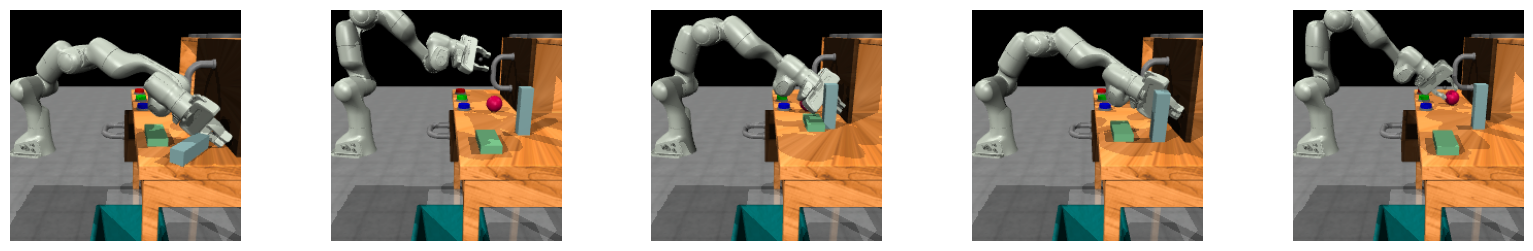

In [113]:
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

rand_i = np.random.choice(np.sum(very_good_inds), 5, replace=False)
ind_list = np.where(very_good_inds)[0][rand_i]
global_t = 0
for i in ind_list:
    env._env._env.physics.set_state(env_state_array_buffer[i])
    env._env._env.physics.forward()
    robodesk_img1 = env._env._env.render(resize=False)
    plt.subplot(1, 5, global_t + 1)
    plt.imshow(robodesk_img1)
    plt.axis("off")
    global_t += 1

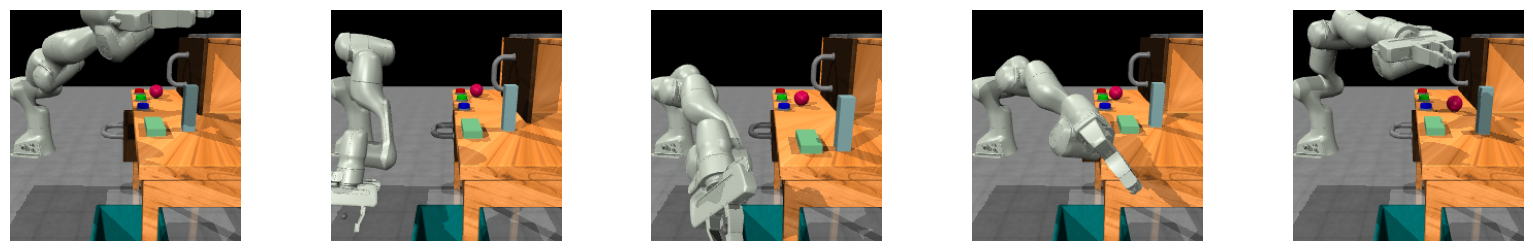

In [114]:
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

rand_i = np.random.choice(np.sum(very_bad_inds), 5, replace=False)
ind_list = np.where(very_bad_inds)[0][rand_i]
global_t = 0
for i in ind_list:
    env._env._env.physics.set_state(env_state_array_buffer[i])
    env._env._env.physics.forward()
    robodesk_img1 = env._env._env.render(resize=False)
    plt.subplot(1, 5, global_t + 1)
    plt.imshow(robodesk_img1)
    plt.axis("off")
    global_t += 1

## Dataset!

In [275]:
num_pairs = 200000

rand_i_1 = np.random.choice(np.sum(very_good_inds), num_pairs, replace=False)
ind_list_good = np.where(very_good_inds)[0][rand_i_1]


rand_i_2 = np.random.choice(np.sum(very_bad_inds), num_pairs, replace=False)
ind_list_bad = np.where(very_bad_inds)[0][rand_i_2]

In [276]:
ind_list_good, ind_list_bad

(array([2175536,  209063, 2012523, ..., 1142558,  119198, 1187854]),
 array([ 699138, 1380294, 2700842, ..., 2124175, 1445204, 2211510]))

In [277]:
save_dataset = True
if save_dataset:
    motif_dataset_dir = (
        "/fast/csancaktar/sensei_datasets/robodesk/plan2explore_multiple_runs_contrastive"
    )
    os.makedirs(motif_dataset_dir, exist_ok=True)
    os.makedirs(os.path.join(motif_dataset_dir, "data"), exist_ok=True)
    os.makedirs(os.path.join(motif_dataset_dir, "preference"), exist_ok=True)


In [278]:
import random

In [279]:
robodesk_image_dataset_highres = np.zeros((num_pairs, 2, 1, width, height, 3), dtype=np.uint8)
env_state_dataset = np.zeros((num_pairs, 2, 1, 73))

preferences = np.zeros((num_pairs,))
pair_indices_dataset = np.zeros((num_pairs, 2))

In [280]:
for pair_i in range(num_pairs):
    pair_good = ind_list_good[pair_i]
    pair_bad = ind_list_bad[pair_i]
    
    good_0_or_1 = random.randint(0, 1)
    
    preferences[pair_i] = good_0_or_1
    
    env_state_dataset[pair_i, good_0_or_1, 0, :] = env_state_array_buffer[pair_good]
    env_state_dataset[pair_i, 1-good_0_or_1, 0, :] = env_state_array_buffer[pair_bad]
    
    env._env._env.physics.set_state(env_state_array_buffer[pair_good])
    env._env._env.physics.forward()
    img_good = env._env._env.render(resize=False)
    
    env._env._env.physics.set_state(env_state_array_buffer[pair_bad])
    env._env._env.physics.forward()
    img_bad = env._env._env.render(resize=False)
    
    robodesk_image_dataset_highres[pair_i, good_0_or_1, 0, ...] = img_good
    robodesk_image_dataset_highres[pair_i, 1-good_0_or_1, 0, ...] = img_bad
    
    pair_indices_dataset[pair_i, good_0_or_1] = pair_good
    pair_indices_dataset[pair_i, 1-good_0_or_1] = pair_bad
    
    if pair_i % 10000 == 0:
        print(f"Rendered {pair_i} pairs already!")

Rendered 0 pairs already!
Rendered 10000 pairs already!
Rendered 20000 pairs already!
Rendered 30000 pairs already!
Rendered 40000 pairs already!
Rendered 50000 pairs already!
Rendered 60000 pairs already!
Rendered 70000 pairs already!
Rendered 80000 pairs already!
Rendered 90000 pairs already!
Rendered 100000 pairs already!
Rendered 110000 pairs already!
Rendered 120000 pairs already!
Rendered 130000 pairs already!
Rendered 140000 pairs already!
Rendered 150000 pairs already!
Rendered 160000 pairs already!
Rendered 170000 pairs already!
Rendered 180000 pairs already!
Rendered 190000 pairs already!


In [307]:
test_i = np.random.choice(num_pairs)

(-0.5, 223.5, 223.5, -0.5)

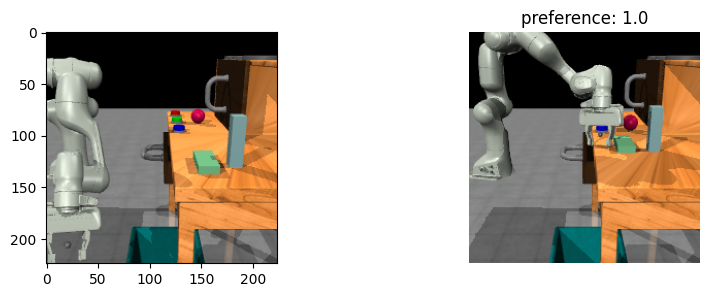

In [308]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.title(f"preference: {preferences[test_i]}")
plt.subplot(1, 2,1)
plt.imshow(robodesk_image_dataset_highres[test_i, 0, 0, ...])

plt.subplot(1, 2, 2)
plt.imshow(robodesk_image_dataset_highres[test_i, 1, 0, ...])

plt.axis("off")


In [289]:
motif_dataset_dir

'/fast/csancaktar/sensei_datasets/robodesk/plan2explore_multiple_runs_contrastive'

In [290]:
np.save(os.path.join(motif_dataset_dir, "preference", "preferences_gt.npy"),preferences)

np.save(os.path.join(motif_dataset_dir, "data", "pair_indices.npy"), pair_indices_dataset)

with open(os.path.join(motif_dataset_dir, "data", f"images.pickle"), "wb") as handle:
    pickle.dump(robodesk_image_dataset_highres, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save(os.path.join(motif_dataset_dir, "data", "env_states.npy"), env_state_dataset)